# Non-Parametric Tests Part I

Up until now, you've been using standard hypothesis tests on means of normal distributions to design and analyze experiments. However, it's possible that you will encounter scenarios where you can't rely on only standard tests. This might be due to uncertainty about the true variability of a metric's distribution, a lack of data to assume normality, or wanting to do inference on a statistic that lacks a standard test. It's useful to know about some **non-parametric tests**, not just as a workaround for cases like this, but also as a second check on your experimental results. The main benefit of non-parametric tests is that they don't rely on many assumptions of the underlying population, and so can be used in a wider range of circumstances compared to standard tests. In this notebook, you'll cover two non-parametric approaches that use resampling of the data to make inferences about distributions and differences.

In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


## Bootstrapping

Bootstrapping is used to estimate sampling distributions by using the actually collected data to generate new samples that could have been hypothetically collected. In a standard bootstrap, a bootstrapped sample means drawing points from the original data _with replacement_ until we get as many points as there were in the original data. Essentially, we're treating the original data as the population: without making assumptions about the original population distribution, using the original data as a model of the population is the best that we can do.

Taking a lot of bootstrapped samples allows us to estimate the sampling distribution for various statistics on our original data. For example, let's say that we wanted to create a 95% confidence interval for the 90th percentile from a dataset of 5000 data points. (Perhaps we're looking at website load times and want to reduce the worst cases.) Bootstrapping makes this easy to estimate. First of all, we take a bootstrap sample (i.e., draw 5000 points with replacement from the original data), record the 90th percentile, and then repeat this a large number of times, let's say 100 000. From this bunch of bootstrapped 90th percentile estimates, we form our confidence interval by finding the values that capture the central 95% of the estimates (cutting off 2.5% on each tail). Implement this operation in the cells below, using the following steps:

- Initialize some useful variables by storing the number of data points in `n_points` and setting up an empty list for the bootstrapped quantile values in `sample_qs`.
- Create a loop for each trial:
  - First generate a bootstrap sample by sampling from our data with replacement. ([`random.choice`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) will be useful here.)
  - Then, compute the `q`th quantile of the sample and add it to the `sample_qs` list. If you're using NumPy v0.15 or later, you can use the [`quantile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.quantile.html) function to get the quantile directly with `q`; on v0.14 or earlier, you'll need to put `q` in terms of a percentile and use [`percentile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html) instead.
- After gathering the bootstrapped quantiles, find the limits that capture the central `c` proportion of quantiles to form the estimated confidence interval.

In [15]:
def quantile_ci(data, q, c = .95, n_trials = 1000):
    """
    Compute a confidence interval for a quantile of a dataset using a bootstrap
    method.
    
    Input parameters:
        data: data in form of 1-D array-like (e.g. numpy array or Pandas series)
        q: quantile to be estimated, must be between 0 and 1
        c: confidence interval width
        n_trials: number of bootstrap samples to perform
    
    Output value:
        ci: Tuple indicating lower and upper bounds of bootstrapped
            confidence interval
    """
    
    # initialize storage of bootstrapped sample quantiles
    n_points = data.shape[0]
    sample_qs = []
    
    # For each trial...
    for _ in range(n_trials):
        # draw a random sample from the data with replacement...
        sample = np.random.choice(data, n_points, replace = True)
        
        # compute the desired quantile...
        sample_q = np.percentile(sample, 100 * q)
        
        # and add the value to the list of sampled quantiles
        sample_qs.append(sample_q)
        
    # Compute the confidence interval bounds
    lower_limit = np.percentile(sample_qs, (1 - c)/2 * 100)
    upper_limit = np.percentile(sample_qs, (1 + c)/2 * 100)
    
    return (lower_limit, upper_limit)

In [16]:
data = pd.read_csv('data/bootstrapping_data.csv')
data.head(10)

,time
0,8152
1,2082
2,3049
3,3317
4,813
5,1442
6,3815
7,2113
8,738
9,2499


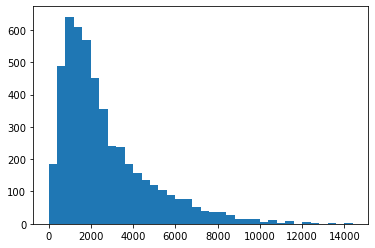

In [17]:
# data visualization
plt.hist(data['time'], bins = np.arange(0, data['time'].max()+400, 400));

In [18]:
lims = quantile_ci(data['time'], 0.9)
print(lims)

(5498.195000000001, 5837.0)


### Bootstrapping Notes

Confidence intervals coming from the bootstrap procedure will be optimistic compared to the true state of the world. This is because there will be things that we don't know about the real world that we can't account for, due to not having a parametric model of the world's state. Consider the extreme case of trying to understand the distribution of the maximum value: our confidence interval would never be able to include any value greater than the largest observed value and it makes no sense to have any lower bound below the maximum observation. Intuitively, however, there's a pretty clear possibility for there to be unobserved values that are larger than the one we've observed, especially for skewed data like shown in the example.

This doesn't override the bootstrap method's advantages, however. The bootstrap procedure is fairly simple and straightforward. Since you don't make assumptions about the distribution of data, it can be applicable for any case you encounter. The results should also be fairly comparable to standard tests. But it does take computational effort, and its output does depend on the data put in. For reference, for the 95% CI on the 90th percentile example explored above, the inferred interval would only capture about 83% of 90th percentiles from the original generating distribution. But a more intricate procedure using a binomial assumption to index on the observed data only does about one percentage point better (84%). And both of these depend on the specific data generated: a different set of 5000 points will produce different intervals, with different accuracies.

Binomial solution for percentile CIs reference: [1](https://www-users.york.ac.uk/~mb55/intro/cicent.htm), [2](https://stats.stackexchange.com/questions/99829/how-to-obtain-a-confidence-interval-for-a-percentile)

## Permutation Tests

The permutation test is a resampling-type test used to compare the values on an outcome variable between two or more groups. In the case of the permutation test, resampling is done on the group labels. The idea here is that, under the null hypothesis, the outcome distribution should be the same for all groups, whether control or experimental. Thus, we can emulate the null by taking all of the data values as a single large group. Applying labels randomly to the data points (while maintaining the original group membership ratios) gives us one simulated outcome from the null.

The rest is similar to the sampling approach used in a standard hypothesis test, except that we haven't specified a reference distribution to sample from – we're sampling directly from the data we've collected. After applying the labels randomly to all the data and recording the outcome statistic many times, we compare our actual, observed statistic against the simulated statistics. A p-value is obtained by seeing how many simulated statistic values are as or more extreme than the one actually observed, and a conclusion is then drawn.

Try implementing a permutation test in the cells below to test if the 90th percentile of times is statistically significantly smaller for the experimental group, as compared to the control group:

- Initialize an empty list to store the difference in sample quantiles as `sample_diffs`.
- Create a loop for each trial:
  - First generate a permutation sample by randomly shuffling the data point labels. ([`random.permutation`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html) will be useful here.)
  - Then, compute the `q`th quantile of the data points that have been assigned to each group based on the permuted labels. Append the difference in quantiles to the `sample_diffs` list.
- After gathering the quantile differences for permuted samples, compute the observed difference for the actual data. Then, compute a p-value from the number of permuted sample differences that are less than or greater than the observed difference, depending on the desired alternative hypothesis.

In [19]:
def quantile_permtest(x, y, q, alternative = 'less', n_trials = 10_000):
    """
    Compute a confidence interval for a quantile of a dataset using a bootstrap
    method.
    
    Input parameters:
        x: 1-D array-like of data for independent / grouping feature as 0s and 1s
        y: 1-D array-like of data for dependent / output feature
        q: quantile to be estimated, must be between 0 and 1
        alternative: type of test to perform, {'less', 'greater'}
        n_trials: number of permutation trials to perform
    
    Output value:
        p: estimated p-value of test
    """
    
    
    # initialize storage of bootstrapped sample quantiles
    sample_diffs = []
    
    # For each trial...
    for _ in range(n_trials):
        # randomly permute the grouping labels
        labels = np.random.permutation(y)
        
        # compute the difference in quantiles
        cond_q = np.percentile(x[labels == 0], 100 * q)
        exp_q  = np.percentile(x[labels == 1], 100 * q)
        
        # and add the value to the list of sampled differences
        sample_diffs.append(exp_q - cond_q)
    
    # compute observed statistic
    cond_q = np.percentile(x[y == 0], 100 * q)
    exp_q  = np.percentile(x[y == 1], 100 * q)
    obs_diff = exp_q - cond_q
    
    # compute a p-value
    if alternative == 'less':
        hits = (sample_diffs <= obs_diff).sum()
    elif alternative == 'greater':
        hits = (sample_diffs >= obs_diff).sum()
    
    return (hits / n_trials)

In [20]:
data = pd.read_csv('data/permutation_data.csv')
data.head(10)

,condition,time
0,0,5940
1,0,666
2,1,571
3,1,779
4,0,1928
5,0,3791
6,0,736
7,1,8482
8,0,4594
9,0,1171


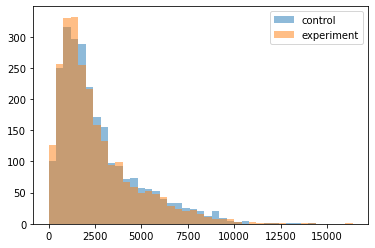

In [21]:
# data visualization
bin_borders = np.arange(0, data['time'].max()+400, 400)
plt.hist(data[data['condition'] == 0]['time'], alpha = 0.5, bins = bin_borders)
plt.hist(data[data['condition'] == 1]['time'], alpha = 0.5, bins = bin_borders)
plt.legend(labels = ['control', 'experiment']);

In [22]:
# Just how different are the two distributions' 90th percentiles?
print(np.percentile(data[data['condition'] == 0]['time'], 90),
      np.percentile(data[data['condition'] == 1]['time'], 90))

5809.199999999999 5492.2


In [23]:
quantile_permtest(data['time'], data['condition'], 0.9,
                  alternative = 'less')

0.0374